In [884]:
import pandas as pd
import seaborn as sns
import re
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline
sns.set()

In [885]:
# Импортируем тестовую выборку и помечаем её
testdf = pd.read_csv('test.csv')
testdf['testdf'] = 1

In [886]:
# Импортируем обучающую выборку и помечаем её
df = pd.read_csv('train.csv')
df['testdf'] = 0

In [887]:
# Соединяем две выборки
df = pd.concat([df, testdf]) 

In [888]:
# Проверяем таблицу на наличие пустых ячеек
df.isnull().sum()/len(df)

PassengerId    0.000000
Survived       0.319328
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.200917
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000764
Cabin          0.774637
Embarked       0.001528
testdf         0.000000
dtype: float64

In [889]:
# Доля всех выживших
df.query("testdf == 0").Survived.value_counts('normalize')

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

<AxesSubplot: xlabel='Pclass', ylabel='Count'>

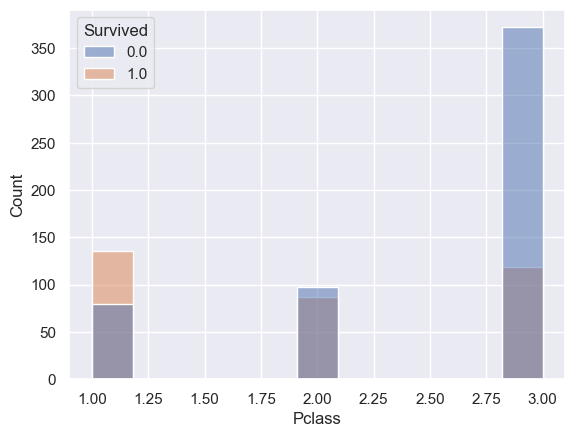

In [890]:
sns.histplot(x='Pclass', hue='Survived', data=df.query("testdf == 0"))
# Наибольшая доля выживших для группы пассажиров 1-го класса,
# наименьшая - 3-го

In [891]:
# Титул пассажира
df['title'] = df.Name.apply(lambda x: re.findall("([A-Za-z]{1,10}\.)", x)[0].replace('.',''))

In [892]:
df.query("testdf == 0")[['title', 'Survived', 'Name']]\
.groupby('title')\
.agg({'Survived': 'mean', 'Name': 'count'})\
.sort_values('Name', ascending=0)

,Survived,Name
title,,
Mr,0.156673,517
Miss,0.697802,182
Mrs,0.792000,125
Master,0.575000,40
Dr,0.428571,7
Rev,0.000000,6
Major,0.500000,2
Col,0.500000,2
Mlle,1.000000,2


In [893]:
# Доля выживших в группах разных полов и классов
# Видно, что самая большая доля выживших находится в группах
# женщин в 1 и 2 классе
df.query("testdf == 0").groupby(['Sex', 'Pclass']).Survived.mean()

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

<AxesSubplot: xlabel='Survived', ylabel='count'>

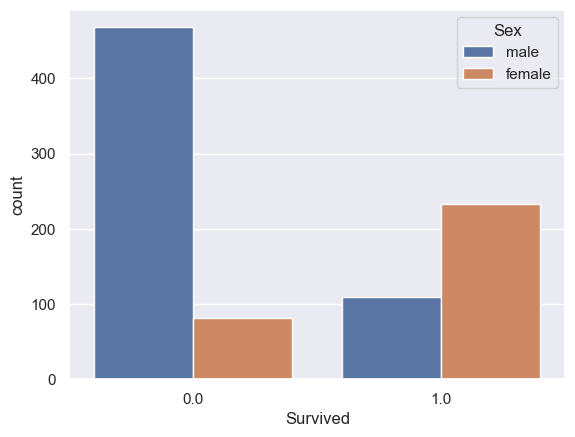

In [894]:
# Видно, что большая часть женщин спаслись, мужчин - нет.
sns.countplot(hue='Sex', x='Survived', data=df.query("testdf == 0"))

<AxesSubplot: xlabel='Age', ylabel='Count'>

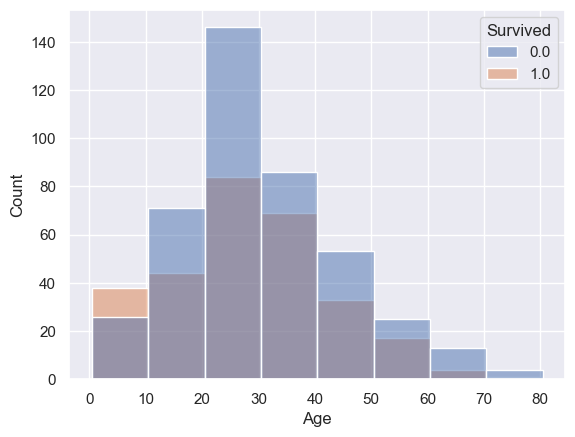

In [895]:
# В группе 0-10 лет доля выживших значительно больше, чем в других
sns.histplot(x='Age', hue='Survived', data=df.query("testdf == 0"), binwidth=10)

In [896]:
# Отнесем каждого пассажира к одной из 8 возрастных групп
df['age_group'] = df.Age.apply(lambda x: 
             '[0-10)' if x >= 0 and x < 10 else         
             '[10-20)' if x >= 10 and x < 20 else
             '[20-30)' if x >= 20 and x < 30 else           
             '[30-40)' if x >= 30 and x < 40 else
             '[40-50)' if x >= 40 and x < 50 else
             '[50-60)' if x >= 50 and x < 60 else
             '[60-70)' if x >= 60 and x < 70 else
             '>=70' if x >= 70 else '')

In [897]:
df.query("testdf == 0")[['age_group', 'Survived', 'Name']]\
.groupby('age_group')\
.agg({'Survived': 'mean', 'Name': 'count'})\
.sort_values('Survived', ascending=0)

,Survived,Name
age_group,,
[0-10),0.612903,62
[30-40),0.437126,167
[50-60),0.416667,48
[10-20),0.401961,102
[40-50),0.382022,89
[20-30),0.350000,220
[60-70),0.315789,19
,0.293785,177
>=70,0.142857,7


<AxesSubplot: xlabel='SibSp', ylabel='Survived'>

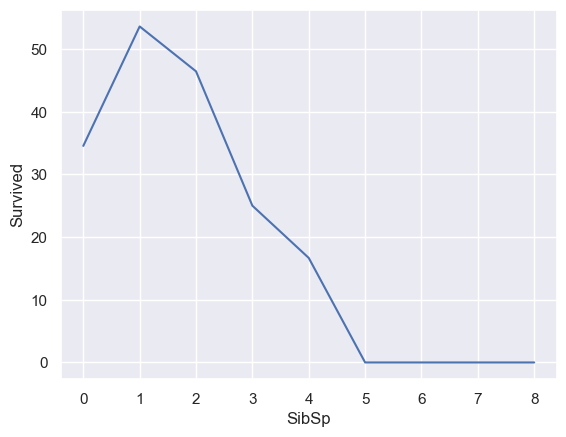

In [898]:
# Выживаемость в зависимости от количества братьев/сестер или супругов, путешествующих вместе с пассажиром
sns.lineplot(df.query("testdf == 0").groupby(['SibSp']).Survived.mean().mul(100))

In [899]:
# Выживаемость в зависимости от количества братьев/сестер или супругов, путешествующих вместе с пассажиром
df.query("testdf == 0")[['SibSp', 'Survived', 'Name']]\
.groupby('SibSp')\
.agg({'Survived': 'mean', 'Name': 'count'})\
.sort_values('SibSp')

,Survived,Name
SibSp,,
0,0.345395,608
1,0.535885,209
2,0.464286,28
3,0.250000,16
4,0.166667,18
5,0.000000,5
8,0.000000,7


<AxesSubplot: xlabel='Parch', ylabel='Survived'>

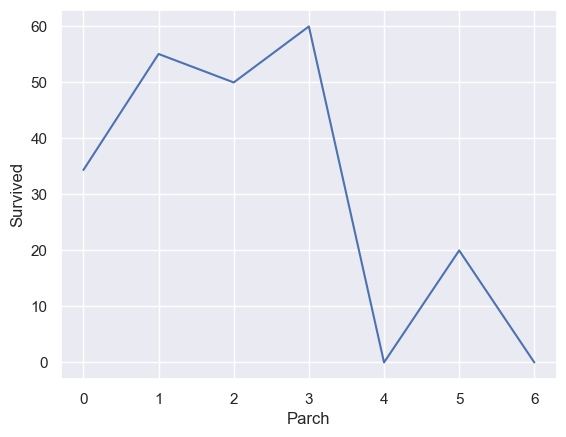

In [900]:
sns.lineplot(data=df.query("testdf == 0").groupby(['Parch']).Survived.mean().mul(100).apply(lambda x: 20 if x == 4 else x))

In [901]:
df.query("testdf == 0")[['Parch', 'Survived', 'Name']]\
.groupby('Parch')\
.agg({'Survived': 'mean', 'Name': 'count'})\
.sort_values('Parch')

,Survived,Name
Parch,,
0,0.343658,678
1,0.550847,118
2,0.500000,80
3,0.600000,5
4,0.000000,4
5,0.200000,5
6,0.000000,1


In [902]:
# "Достанем" из 'Cabin' букву палубы и номер каюты
def fff(x):
    if len(x)>1 :
        lst = re.findall("([A-Z]\d{1,3})", x)
        letter = re.findall("([A-Z])", lst[math.floor(len(lst)/2)])[0]
        num = re.findall("(\d{1,3})", lst[math.floor(len(lst)/2)])[0]
        return [letter, num]
    else:
        return ''

df['cabin_letter'] = df.Cabin.fillna('')\
    .apply(lambda x: fff(x)[0] if len(x)>1 else None)

df['cabin_num'] = df.Cabin.fillna('')\
    .apply(lambda x: float(fff(x)[1]) if len(x)>1 else None)

<AxesSubplot: xlabel='cabin_num', ylabel='Count'>

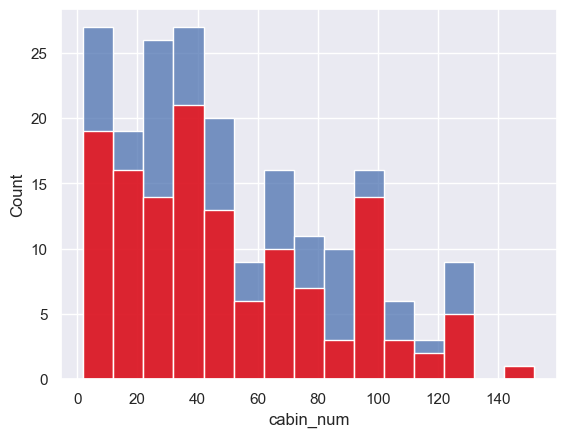

In [903]:
sns.histplot(x='cabin_num', data=df.query("testdf == 0"), binwidth=10)
sns.histplot(x='cabin_num', data=df.query("testdf == 0").query("Survived == 1"), color='red', binwidth=10)

In [904]:
df['cabin_num_group'] = df.cabin_num.apply(lambda x: 
            '[0-30)' if x >= 0 and x < 30 else 
            '[30-60)' if x >= 30 and x < 60 else
            '[60-90)' if x >= 60 and x < 90 else
            '[90-120)' if x >= 90 and x < 120 else
            '[120-150)' if x >= 120 and x < 150 else
            '>=150' if x >= 150 else '')

In [905]:
# выживаемость в зависимости от каюты
# При указанной каюте выживаемость выше в 2 раза
df.query("testdf == 0")[['cabin_num_group', 'Survived', 'Name']]\
.groupby('cabin_num_group')\
.agg({'Survived': 'mean', 'Name': 'count'})\
.sort_values('Name', ascending=0)

,Survived,Name
cabin_num_group,,
,0.301013,691
[0-30),0.716418,67
[30-60),0.677966,59
[60-90),0.540541,37
[90-120),0.720000,25
[120-150),0.666667,12


In [906]:
# выживаемость в зависимости от палубы
# как видно выжываемость на палубе G минимальна, B,D,E,F примерно одинакова
df.query("testdf == 0").fillna('')[['cabin_letter', 'Survived', 'Name']]\
.groupby('cabin_letter')\
.agg({'Survived': 'mean', 'Name': 'count'})

,Survived,Name
cabin_letter,,
,0.301013,691
A,0.466667,15
B,0.744681,47
C,0.593220,59
D,0.766667,30
E,0.757576,33
F,0.777778,9
G,0.285714,7


In [907]:
# Количество человек, путешествующих по билету
qty_people_in_ticket = df.groupby('Ticket').Name.count().reset_index().rename(columns={'Name' : 'qty_people_in_ticket'})

df = df.merge(qty_people_in_ticket, on='Ticket', how='left')

# Тариф на одного человека
df['Fare_per_person'] = df[['Fare', 'qty_people_in_ticket']].apply(lambda x: x.Fare/x.qty_people_in_ticket, axis=1)

<AxesSubplot: xlabel='Fare_per_person', ylabel='Count'>

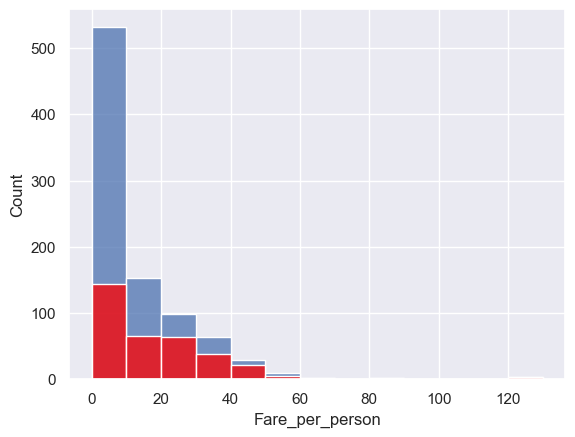

In [908]:
# С повышением стоимости билета, увеличивается доля выживших
sns.histplot(x='Fare_per_person', data=df.query("testdf == 0").query("Fare_per_person >= 0"), binwidth=10)
sns.histplot(x='Fare_per_person', data=df.query("testdf == 0").query("Fare_per_person >= 0 and Survived == 1"), color='red', binwidth=10)

In [909]:
df['Fare_group'] = df.Fare_per_person.apply(lambda x: 
                '[0-10)' if x >= 0 and x < 10 else 
                '[10-20)' if x >= 10 and x < 20 else
                '[20-30)' if x >= 20 and x < 30 else
                '[30-40)' if x >= 30 and x < 40 else
                '[40-50)' if x >= 40 and x < 50 else
                '>=50' if x >= 50 else '')

In [910]:
# С повышением тарифа возрастает выживаемость
df.query("testdf == 0")[['Fare_group', 'Survived', 'Name']]\
.groupby('Fare_group')\
.agg({'Survived': 'mean', 'Name': 'count'})\
.sort_values('Name', ascending=0)

,Survived,Name
Fare_group,,
[0-10),0.268797,532
[10-20),0.427632,152
[20-30),0.653061,98
[30-40),0.593750,64
[40-50),0.724138,29
>=50,0.687500,16


In [911]:
# "Достаем" серию билета
df['Ticket_type'] = df.Ticket\
.apply(lambda x: re.sub('[^A-Za-z0-9]', '', x.split()[0])\
                           .upper()\
                           .replace('AS', 'A5') 
       if x.find(' ') != -1 
       else '')

In [912]:
# Для билетов серий 'PC' и 'CA' выживаемость выше, чем для остальных
df.query("testdf == 0")[['Ticket_type', 'Survived', 'Name']]\
.groupby('Ticket_type')\
.agg({'Survived': 'mean', 'Name': 'count'})\
.sort_values("Name", ascending=0).head(5)

,Survived,Name
Ticket_type,,
,0.383459,665
PC,0.650000,60
CA,0.341463,41
A5,0.090909,22
SOTONOQ,0.133333,15


In [913]:
# Видно, что наибольший шанс на выживание имели пассажиры, отправляющиеся из порта "С"
df.query("testdf == 0")[['Embarked', 'Survived', 'Name']]\
.groupby('Embarked')\
.agg({'Survived': 'mean', 'Name': 'count'})

,Survived,Name
Embarked,,
C,0.553571,168
Q,0.389610,77
S,0.336957,644


In [914]:
# Приведем выбранные признаки влияющие на выживаемость к числовому виду
# на основании выводов сделанных выше

In [915]:
df['_Survived'] = df.query("testdf == 0").Survived.astype('Int64')

In [916]:
df['_Pclass'] = df.Pclass.astype(int)

In [917]:
df['_Sex'] = df.Sex.map({"male": 1, "female": 2}).fillna(1)

In [918]:
df['_Age'] = df.age_group.map(
    {"[0-10)": 0, "[10-20)": 1, "[30-40)": 1, "[50-60)": 1, "[20-30)": 2, "[40-50)": 2,
    "[60-70)": 3, '>=70': 4}
    ).fillna(3).astype(int)

In [919]:
df['_SibSp'] = df.SibSp.map({1: 0, 2: 0, 0: 1, 3: 2, 4: 3}).fillna(4).astype(int)

In [920]:
df['_Parch'] = df.Parch.map({1: 0, 2: 0, 0: 1}).fillna(2).astype(int)

In [921]:
#df['_Cabin'] = df.Cabin.fillna(1).apply(lambda x: 0 if x != 1 else 1)

In [922]:
df['_Cabin_num'] = df.cabin_num_group.map(
    {"[0-30)": 1, "[30-60)": 1, "[90-120)": 1, 
     "[120-150)": 1, "[60-90)": 2}
    ).fillna(0).astype(int)

In [923]:
df['_cabin_letter'] = df.cabin_letter.map(
    {"B": 1, "D": 1, "E": 1, "F": 1, 
     "C": 2, "A": 3, "G": 4}
    ).fillna(4).astype(int)

In [924]:
df['_Ticket'] = df.Ticket_type.map({"PC": 1, "CA": 2, "A5": 3, "SOTONOQ": 3}).fillna(4).astype(int)

In [925]:
df['_Embarked'] = df.Embarked.map({"C": 1, "Q": 2, "S": 3}).fillna(3).astype(int)

In [926]:
df['_Fare'] = df.Fare_group.map(
    {">=50": 0, "[40-50)": 0, "[20-30)": 1, 
     "[30-40)": 1, "[10-20)":2, "[0-10)": 3}
    ).fillna(3).astype(int)

In [927]:
df['_Name'] = df.title.map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4}).fillna(5).astype(int)

In [928]:
# Проверим, насколько коррелируют между собой выбранные признаки
# Это может быть полезно при настройке ML модели 
df.query("testdf == 0").iloc[:,22:].corr()

,_Survived,_Pclass,_Sex,_Age,_SibSp,_Parch,_Cabin_num,_cabin_letter,_Ticket,_Embarked,_Fare,_Name
_Survived,1.000000,-0.338481,0.543351,-0.156473,-0.197131,-0.159978,0.275739,-0.337442,-0.093167,-0.167675,-0.320592,0.414088
_Pclass,-0.338481,1.000000,-0.131900,0.058347,0.208365,0.065027,-0.672541,0.707162,0.302988,0.162098,0.924635,-0.184841
_Sex,0.543351,-0.131900,1.000000,-0.115812,-0.109318,-0.177422,0.140186,-0.154158,-0.040530,-0.108262,-0.141765,0.508099
_Age,-0.156473,0.058347,-0.115812,1.000000,-0.017654,0.309137,-0.081270,0.071874,0.010947,-0.108335,0.015313,-0.238217
_SibSp,-0.197131,0.208365,-0.109318,-0.017654,1.000000,-0.151757,-0.161480,0.152673,-0.076276,0.115167,0.178023,-0.019919
_Parch,-0.159978,0.065027,-0.177422,0.309137,-0.151757,1.000000,-0.121422,0.126512,0.076333,0.022943,0.022914,-0.292148
_Cabin_num,0.275739,-0.672541,0.140186,-0.081270,-0.161480,-0.121422,1.000000,-0.876283,-0.226981,-0.177892,-0.664770,0.132416
_cabin_letter,-0.337442,0.707162,-0.154158,0.071874,0.152673,0.126512,-0.876283,1.000000,0.201624,0.149953,0.678334,-0.143418
_Ticket,-0.093167,0.302988,-0.040530,0.010947,-0.076276,0.076333,-0.226981,0.201624,1.000000,0.231576,0.335335,-0.077437
_Embarked,-0.167675,0.162098,-0.108262,-0.108335,0.115167,0.022943,-0.177892,0.149953,0.231576,1.000000,0.211157,-0.074312


<AxesSubplot: >

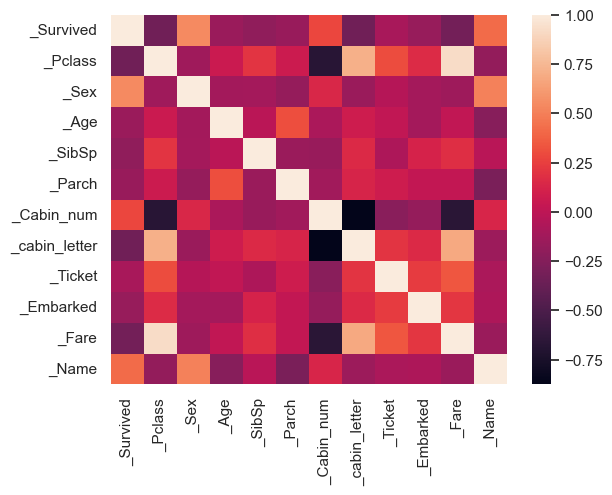

In [929]:
sns.heatmap(df.query("testdf == 0").iloc[:,22:].corr())

In [930]:
# Определим независимые и зависимые данные
X=df.query("testdf == 0").iloc[:,23:]
y=df.query("testdf == 0")['_Survived'].astype(int)

In [931]:
# Выберем параметры для "перебора" при выборе лучшей модели
model_param = {
    'DecisionTreeClassifier':{
        'model':DecisionTreeClassifier(),
        'param':{'criterion': ['gini','entropy']}
    },
        'KNeighborsClassifier':{
        'model':KNeighborsClassifier(),
        'param':{'n_neighbors': [5,10,15,20,25]}
    },
        'SVC':{
        'model':SVC(),
        'param':{'kernel':['rbf','linear','sigmoid'],
            'C': [0.1, 1, 10, 100]}
    },
        'RandomForestClassifier':{
        'model':RandomForestClassifier(),
        'param':{'n_estimators': [100, 200, 300, 400],
                 'criterion': ['gini','entropy'],
                 'max_features': [4, 5, 6, 7],
                 'max_depth': [5, 6, 7, 8]}
    },
        'GradientBoostingClassifier':{
        'model':GradientBoostingClassifier(),
        'param':{'learning_rate':[0.1, 1, 10, 100],
            'n_estimators': [700, 300, 100]}
    
    }
}

In [932]:
scores =[]
for model_name, mp in model_param.items():
    model_selection = GridSearchCV(estimator=mp['model'],param_grid=mp['param'],cv=5,return_train_score=False)
    model_selection.fit(X,y)
    scores.append({
        'model': model_name,
        'best_score': model_selection.best_score_,
        'best_params': model_selection.best_params_
    })

In [933]:
# Наилучший результат показал метод случайного леса
df_model_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_model_score

,model,best_score,best_params
0,DecisionTreeClassifier,0.799102,{'criterion': 'entropy'}
1,KNeighborsClassifier,0.811474,{'n_neighbors': 10}
2,SVC,0.829452,"{'C': 100, 'kernel': 'rbf'}"
3,RandomForestClassifier,0.845120,"{'criterion': 'gini', 'max_depth': 6, 'max_fea..."
4,GradientBoostingClassifier,0.832810,"{'learning_rate': 0.1, 'n_estimators': 100}"


In [948]:
df_model_score.best_params[3]

{'criterion': 'gini', 'max_depth': 6, 'max_features': 4, 'n_estimators': 100}

In [949]:
# Обучим модель
model = RandomForestClassifier(criterion='gini',max_depth=6, max_features=4, n_estimators=100).fit(X, y)

In [950]:
# Используем модель на тестовой выборке
y_predicted = model.predict(df.query("testdf == 1").iloc[: , 23:])

In [951]:
sub = pd.DataFrame({'Survived': y_predicted}, index=df.query("testdf == 1")['PassengerId'])

In [952]:
sub.to_csv('RFCtitanic_sub_v6.csv')

In [938]:
# Загружаем RFCtitanic_sub_v6.csv на www.kaggle.com
# Результат - модель верно определяет выживаемость в 78% случаев.